In [1]:
!pip install noisereduce


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import numpy as np
from glob import glob
import noisereduce as nr
import random

In [3]:
import librosa.display
import IPython

In [4]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses

2022-12-01 11:37:29.700301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
data_dir = '/Volumes/CE_CADDY/TRAINING_SAMPLES/Kicks_Preprocessed_0.5s'

In [24]:
audiofiles = glob(data_dir + '/*.npy')

In [25]:
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

In [26]:
data = load_data(data_dir)

In [28]:
np.isnan(data).sum()

0

In [9]:
def remove_nans(data):
    if np.isnan(data).sum() > 0:
        a = data.shape[1]
        b = data.shape[2]
        good_data_total = int(data.shape[0] - (np.isnan(data).sum() / (a * b)))
        data = data[~np.isnan(data)]
        data = data.reshape(good_data_total, a,b)
        return data
    return data



In [10]:
data = remove_nans(data)

In [11]:
data.shape

(6561, 256, 94)

In [12]:
X_train = data[:5000, :, :]

In [13]:
X_valid = data[5000:6560, :, :]

imports

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [29]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [15]:
codings_size = 10

encoder, mean and log_var take in same input from second layer hense not being sequential

In [30]:
inputs = layers.Input(shape=[256,94])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder

In [32]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(256 * 94, activation='sigmoid')(x)
outputs = layers.Reshape([256, 94])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [33]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

custom KL Loss

In [34]:
loss=losses.kullback_leibler_divergence

In [35]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/256*94)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [36]:
from tensorflow.keras.callbacks import EarlyStopping


In [37]:
es = EarlyStopping(patience=10,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
40/40 [==============================] - 9s 185ms/step - loss: 42453918810112.0000 - val_loss: 2.9373
Epoch 2/100
40/40 [==============================] - 7s 162ms/step - loss: 3.6388 - val_loss: 2.0588
Epoch 3/100
40/40 [==============================] - 6s 158ms/step - loss: 2.8183 - val_loss: 1.6143
Epoch 4/100
40/40 [==============================] - 7s 178ms/step - loss: 2.3858 - val_loss: 1.4523
Epoch 5/100
40/40 [==============================] - 7s 179ms/step - loss: 2.0916 - val_loss: 1.0884
Epoch 6/100
40/40 [==============================] - 7s 173ms/step - loss: 1.7482 - val_loss: 0.7090
Epoch 7/100
40/40 [==============================] - 6s 162ms/step - loss: 1.4593 - val_loss: 0.4253
Epoch 8/100
40/40 [==============================] - 7s 179ms/step - loss: 1.1335 - val_loss: 0.2196
Epoch 9/100
40/40 [==============================] - 7s 178ms/step - loss: 0.8598 - val_loss: 0.2614
Epoch 10/100
40/40 [==============================] - 7s 188ms/step - loss: 0.

In [130]:
codings = tf.random.normal(shape=[10, codings_size],stddev=5)
images = variational_decoder(codings).numpy()

In [98]:
images

array([[[0.6327758 , 0.74103516, 0.7903381 , ..., 0.20205869,
         0.22619635, 0.20258808],
        [0.6753616 , 0.84314066, 0.9032041 , ..., 0.22054164,
         0.21533056, 0.21599999],
        [0.69581383, 0.864652  , 0.88367236, ..., 0.16687587,
         0.16804776, 0.15785445],
        ...,
        [0.0153398 , 0.00774738, 0.00829817, ..., 0.00789314,
         0.00765477, 0.00741565],
        [0.01387767, 0.00796764, 0.00735624, ..., 0.00844955,
         0.00812369, 0.00896422],
        [0.01483026, 0.00718437, 0.00769193, ..., 0.00825522,
         0.00704234, 0.00817455]],

       [[0.60150856, 0.7099908 , 0.71171397, ..., 0.26882312,
         0.28232867, 0.23994932],
        [0.6363027 , 0.78653526, 0.8632339 , ..., 0.27132243,
         0.25667948, 0.27437356],
        [0.6619211 , 0.81168336, 0.8260922 , ..., 0.2353455 ,
         0.21737741, 0.21198115],
        ...,
        [0.0303973 , 0.02108591, 0.02055879, ..., 0.02011283,
         0.01974639, 0.02121885],
        [0.0

In [40]:
variational_ae.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 94)]    0           []                               
                                                                                                  
 model_3 (Functional)           [(None, 10),         3626870     ['input_3[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 model_5 (Functional)           (None, 256, 94)      3649914     ['model_3[0][2]']                
                                                                                            

In [41]:
hop_length = 300
win_length = 1200
sr = 48000
# spec = librosa.db_to_amplitude(images[5])

In [ ]:
# signal = librosa.istft(spec, n_fft=1200, hop_length=hop_length, win_length=win_length, dtype='float32')
# librosa.griffinlim(S, *, n_iter=32, hop_length=None, win_length=None, n_fft=None, window='hann', center=True, dtype=None, length=None, pad_mode='constant', momentum=0.99, init='random', random_state=None)
f = librosa.griffinlim(images[1], n_iter=32, hop_length=300)
# f = IPython.display.Audio(f, rate=48000)
nred1 = nr.reduce_noise(y=f, sr=sr, stationary=True)
# librosa.effects.pitch_shift(y, *, sr, n_steps, bins_per_octave=12, res_type='kaiser_best', **kwargs)
# nred2 = librosa.effects.pitch_shift(nred, sr=sr, n_steps = -12, bins_per_octave=12, res_type='fft')
nredkaiser = librosa.effects.pitch_shift(nred, sr=sr, n_steps = -12, bins_per_octave=12, res_type='kaiser_best')


In [ ]:
# librosa.pcen(S, *, sr=22050, hop_length=512, gain=0.98, bias=2, power=0.5, time_constant=0.4, eps=1e-06, b=None, max_size=1, ref=None, axis=-1, max_axis=None, zi=None, return_zf=False)

In [175]:
def postproc_and_play(generated_spectrogram):
    #sample rate
    sr = 48000
    # random value to pitch down sample
    pdown = random.uniform(-30, -16)
    # spectrogram back to audio
    new_kick = librosa.griffinlim(generated_spectrogram, n_iter=32, hop_length=300)
    # noise reduction on audio
    new_kick_nr = nr.reduce_noise(y=new_kick, sr=sr, stationary=True)
    # pitch down audio by random amount
    new_kick_final = librosa.effects.pitch_shift(new_kick_nr, sr=sr, n_steps = pdown, bins_per_octave=16, res_type='kaiser_best')
    # display waveform and return player for audio file
    librosa.display.waveshow(new_kick_final,sr=sr)
    return IPython.display.Audio(new_kick_final, rate=sr)


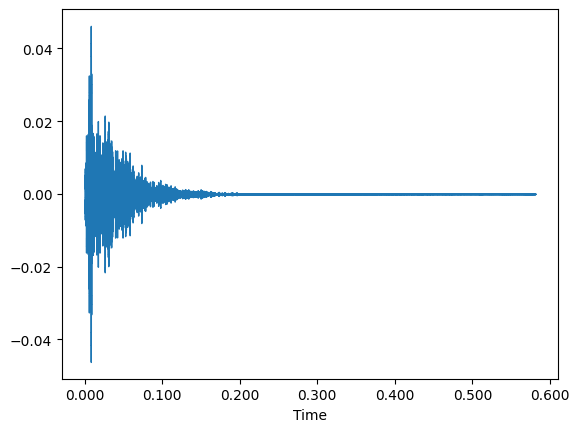

In [178]:
postproc_and_play(images[1])

In [ ]:
postproc_and_play(images[1])

In [ ]:
IPython.display.Audio(nred1, rate=sr)

In [ ]:
IPython.display.Audio(nredkaiser, rate=sr)

In [48]:
new = librosa.griffinlim(images[1], n_iter=32, hop_length=300)

In [50]:
new_nr = nr.reduce_noise(y=new, sr=sr, stationary=True)


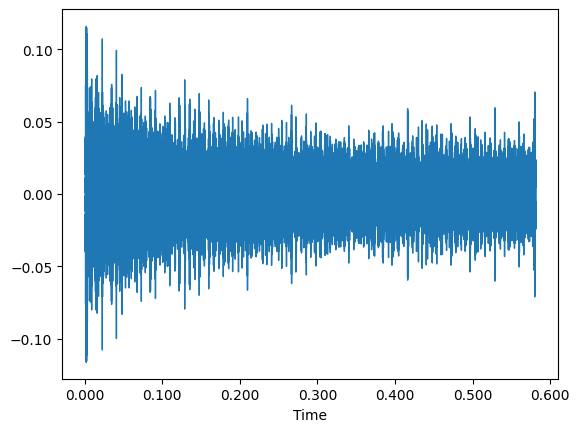

In [51]:
librosa.display.waveshow(new,sr=48000)

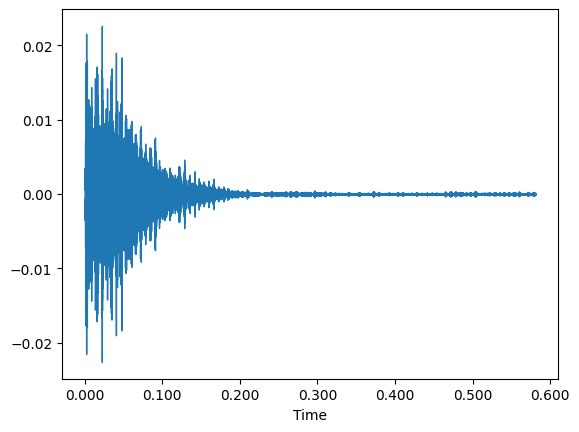

In [53]:
librosa.display.waveshow(new_nr,sr=48000)

In [ ]:
librosa.display.specshow(images[1])

In [ ]:
# np.save("/Users/felixm/Downloads/",images)